In [1]:
import torch
import torch.nn as nn

# Multi-head Attention


Building Block:

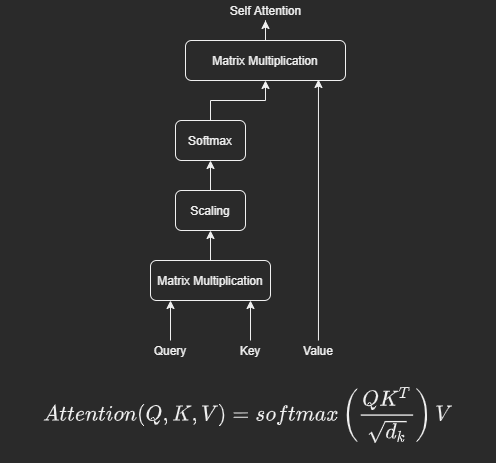

In [2]:
class MultiHeadAttention(nn.Module):
  def __init__(self,embed_size,heads):
    super(MultiHeadAttention,self).__init__()
    '''
    heads : how many parts are we going to split the word embedding
    embed_size : size of word embedding
    '''
    self.embed_size = embed_size
    self.heads = heads
    self.head_dim = embed_size // heads # integer division

    assert (self.head_dim * heads == embed_size), "embed_size needs to be divisible by heads"

    self.values = nn.Linear(self.head_dim,self.head_dim,bias=False)
    self.keys = nn.Linear(self.head_dim,self.head_dim,bias=False)
    self.queries = nn.Linear(self.head_dim,self.head_dim,bias=False)
    self.fc_out = nn.Linear(heads*self.head_dim,embed_size)

  def forward(self, values, keys, queries, mask):
    '''
    N : no. of training examples
    '''
    N = queries.shape[0]
    value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

    # Split embedding into self.head pieces
    values = values.reshape(N, value_len, self.heads, self.head_dim)
    values = self.values(values)
    keys = keys.reshape(N, key_len, self.heads, self.head_dim)
    keys = self.keys(keys)
    queries = queries.reshape(N, query_len, self.heads, self.head_dim)
    queries = self.queries(queries)
  
    '''
    queries shape: (N, query_len, heads, heads_dim)
    keys shape: (N, key_len, heads, heads_dim)
    score shape: (N, heads, query_len, key_len)
    '''
    score = torch.einsum("nqhd,nkhd->nhqk", [queries,keys]) 
    # Sums the product of the elements of the input operands along dimensions specified using a notation based on the Einstein summation convention.

    if mask is not None:
      score = score.masked_fill(mask == 0, float("-1e20"))
    
    attention = torch.softmax(score / (self.embed_size ** (1/2)), dim=3)

    '''
    attention shape: (N, heads, query_len, key_len)
    values shape: (N, value_len, heads, heads_dim)
    out shape: (N, query_len, heads, heads_dim)
    key_len and value_len are always same
    '''
    out = torch.einsum("nhql,nlhd->nqhd", [attention,values]).reshape(
        N, query_len, self.heads*self.head_dim
    )
    
    out = self.fc_out(out)
    return out


# Transformer Block

In [3]:
class TransformerBlock(nn.Module):
  def __init__(self,embed_size,heads,dropout,forward_expansion):
    super(TransformerBlock,self).__init__()
    self.attention = MultiHeadAttention(embed_size,heads)
    self.norm = nn.LayerNorm(embed_size)          #LayerNorm takes an average of every single example

    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size,forward_expansion*embed_size),
        nn.ReLU(),
        nn.Linear(forward_expansion*embed_size,embed_size)
    )
    self.dropout=nn.Dropout(dropout)
  
  def forward(self,value,key,query,mask):
    attention = self.attention(value,key,query,mask)

    x = self.norm(attention + query)              # residual connection 
    x = self.dropout(x)
    forward = self.feed_forward(x)

    out = self.dropout(self.norm(forward + x))
    return out


# Encoder

In [4]:
class Encoder(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      embed_size,
      num_layers,
      heads,
      device,
      forward_expansion,
      dropout,
      max_length
  ):
    super(Encoder,self).__init__()
    self.embed_size = embed_size
    self.device = device
    self.word_embedding = nn.Embedding(src_vocab_size,embed_size)
    self.positional_encoding = nn.Embedding(max_length, embed_size)

    self.layers=nn.ModuleList(
        [
         TransformerBlock(
             embed_size=embed_size,
             heads=heads,
             dropout=dropout,
             forward_expansion=forward_expansion
         ) for _ in range(num_layers)
        ]
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask):
    '''
    x: input
    N: no. of samples
    '''
    N, seq_len = x.shape
    positions = torch.arange(0,seq_len).expand(N,seq_len).to(self.device)

    sum = self.word_embedding(x) + self.positional_encoding(positions)
    out = self.dropout(sum)

    for layer in self.layers:
      out = layer(out, out, out, mask)
    
    return out


# Decoder Block

In [5]:
class DecoderBlock(nn.Module):
  def __init__(self,embed_size,heads,forward_expansion,dropout,device):
    super(DecoderBlock,self).__init__()
    self.attention = MultiHeadAttention(embed_size,heads)
    self.norm = nn.LayerNorm(embed_size)
    self.transformer_block = TransformerBlock(
        embed_size=embed_size,
        heads=heads,
        dropout=dropout,
        forward_expansion=forward_expansion
    )
    self.dropout=nn.Dropout(dropout)
  
  def forward(self, x, value, key, src_mask, trg_mask):
    attention = self.attention(x,x,x,trg_mask)   # Masked Multi-head Attention
    query = self.dropout(self.norm(attention + x))
    out = self.transformer_block(value,key,query,src_mask) # Cross Attention
    return out


# Decoder

In [6]:
class Decoder(nn.Module):
  def __init__(
      self,
      trg_vocab_size,
      embed_size,
      num_layers,
      heads,
      forward_expansion,
      dropout,
      device,
      max_length
  ):
    super(Decoder,self).__init__()
    self.device = device
    self.word_embedding = nn.Embedding(trg_vocab_size,embed_size)
    self.positional_encoding = nn.Embedding(max_length, embed_size)

    self.layers=nn.ModuleList(
        [
         DecoderBlock(
             embed_size=embed_size,
             heads=heads,
             dropout=dropout,
             forward_expansion=forward_expansion,
             device=device
         ) for _ in range(num_layers)
        ]
    )
    self.fc_out = nn.Linear(embed_size,trg_vocab_size)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x, enc_out, src_mask, trg_mask):
    N, seq_len = x.shape
    positions = torch.arange(0,seq_len).expand(N,seq_len).to(self.device)

    sum = self.word_embedding(x) + self.positional_encoding(positions)
    x = self.dropout(sum)

    for layer in self.layers:
      x = layer(x, enc_out, enc_out, src_mask, trg_mask)
    
    out = self.fc_out(x)

    return out

# Transformer

In [7]:
class Transformer(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      trg_vocab_size,
      src_pad_idx,
      trg_pad_idx,
      embed_size=256,
      num_layers=6,
      forward_expansion=4,
      heads=8,
      dropout=0,
      device="cuda",
      max_length=100
  ):
    super(Transformer,self).__init__()
    self.encoder = Encoder(
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length
    )

    self.decoder = Decoder(
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length
    )

    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self,src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    '''
    unsqueeze => Returns a new tensor with a dimension of size one inserted at the specified position
    shape: (N,1,1,src_len)
    '''
    return src_mask.to(self.device)
    
  def make_trg_mask(self,trg):
    N, trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len,trg_len))).expand(
        N,1,trg_len,trg_len
    )
    '''
    tril => Returns the lower triangular part of the matrix (2-D tensor) or batch of matrices input, 
    the other elements of the result tensor out are set to 0.
    '''
    return trg_mask.to(self.device)

  def forward(self,src,trg):
      src_mask = self.make_src_mask(src)
      trg_mask = self.make_trg_mask(trg)
      enc_src = self.encoder(src,src_mask)
      out = self.decoder(trg,enc_src,src_mask,trg_mask)
      return out

# Random for testing if it works like Aladdin Persson

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(device)
trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

src_pad_idx = 0
trg_pad_idx = 0
src_vocab_size = 10
trg_vocab_size = 10

model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(device)
out = model(x, trg[:, :-1])
print(out.shape)
print(out)

cpu
torch.Size([2, 7, 10])
tensor([[[ 0.4635, -0.3002,  0.9205, -0.7402,  0.8496,  1.3373, -1.3289,
          -0.3949, -0.9022,  0.9897],
         [-0.4332,  0.1162,  0.3425, -0.6345,  1.8678,  0.5845, -0.6565,
           0.5286,  0.0223,  0.0326],
         [ 0.3941,  0.2565, -0.0164,  0.6667,  0.9650,  0.3436, -0.8920,
           0.6018, -0.4314,  0.6588],
         [ 0.1459, -0.3495, -0.0086, -0.7977,  0.4699,  0.0408, -0.5372,
           0.9785, -0.4239,  1.3883],
         [ 0.2328, -0.2368,  0.2211, -0.6090,  0.8816,  0.4349, -0.2697,
           0.2683, -0.1391,  0.4517],
         [ 0.2088, -0.0907, -0.2527, -0.2650,  0.7583,  0.3105, -0.7401,
           0.7444, -0.0753,  0.2339],
         [ 0.7131, -0.4184, -0.8899, -0.4007,  0.7148,  1.3451, -1.3061,
           0.3935, -0.5869,  0.1968]],

        [[ 0.5083, -0.2752,  0.8991, -0.9126,  1.0155,  1.3529, -1.2465,
          -0.5026, -0.7590,  0.8793],
         [ 0.0104,  0.0803,  0.2166, -1.1111,  1.3068,  0.8954, -0.6328,
          